In [229]:
import numpy as np
import scipy.misc # to visualize only
import os
from PIL import Image
import pickle
import h5py
import cv2
import matplotlib.pyplot as plt
import imutils
import time

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
path='/content/drive/My Drive/Colab Notebooks/Comp551_P3/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [230]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.utils import np_utils

In [239]:
# Load dataset
f = h5py.File(path+'MNIST_synthetic.h5','r')
x_train = np.array(f.get('train_dataset'))
y_train = np.array(f.get('train_labels'))
x_test = np.array(f.get('test_dataset'))

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)

(56000, 64, 64, 1)
(56000, 5)
(14000, 64, 64, 1)


In [232]:
def isolate_digits (img):
  x_space_coord = []
  y_space_coord = []

  sum_thresh = 0    # If sum of all pixels is above this threshold, then we found a digit
  on_digit = False

  req_num_counts = 3        # We need to detect a digit at least this many number of times to consider it a digit
  digit_count = 0
  empty_count = 0

  # Slide a vertical rectangle to detect empty spaces between digits
  rect_width = 3
  for x in range(img.shape[1] - rect_width):

    rect_window = img[:,x:x+rect_width]
    s = np.sum(rect_window)

    # We may have found a digit
    if s > sum_thresh:
      digit_count += 1
      empty_count = 0
      if  digit_count >= req_num_counts and on_digit == False:
        on_digit = True
        x_space_coord.append(x - 5) if len(x_space_coord) % 2 == 0 else x_space_coord.append(x + 5 - rect_width)

    # We may have found a space between digits
    else:
      empty_count += 1
      digit_count = 0
      if  empty_count >= req_num_counts and on_digit == True:
        on_digit = False
        x_space_coord.append(x - 5) if len(x_space_coord) % 2 == 0 else x_space_coord.append(x + 5 - rect_width)

  y1 = 100
  y2 = 200

  # The segmented images won't have the same shape, we can resize them later
  digit_imgs = []

  for i, x1 in enumerate(x_space_coord[::2]):
    x2 = x_space_coord[2 * i + 1]
    digit_imgs.append(cv2.resize(img[y1:y2, x1:x2], (50, 100)))

  # for i, d_img in enumerate(digit_imgs):
  #   plt.subplot(1, len(digit_imgs), i+1), plt.imshow(cv2.resize(d_img, (50, 100)))
  # plt.show()

  return digit_imgs

In [233]:
def preprocess_img_data(data, train=True):

  segmented_img_list = []
  t0 = time.time()
  count = 0
  for i, img in enumerate(data):

    # if i == data.shape[0] / 10:
    # print(i)
      # print("{}% done in {}s".format(int(i / data.shape[0] * 100), time.time()-t0))
    # Get image array and resize
    img = Image.fromarray(np.uint8(img[:,:,0]))
    newsize = (300, 300) 
    im1 = img.resize(newsize)
    cimg = cv2.cvtColor(np.array(im1), cv2.COLOR_RGB2BGR)
    # plt.imshow(cimg)
    gray = cv2.cvtColor(cimg, cv2.COLOR_BGR2GRAY)
    # plt.imshow(gray)
    # Apply Gaussian filter to image
    blurred = cv2.GaussianBlur(gray, (5,5), 0) 
    # plt.imshow(blurred)
    # Find edges using the Canny Edge detector
    edged = cv2.Canny(blurred, 50, 200, 255)
    # plt.imshow(edged)
    # Find the digit countours
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    displayCnt = None
    # print(cnts)
    # Fill the countours
    thresh = cv2.threshold(blurred, 0, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    # plt.imshow(thresh)
    # Isolate single digits in the image
    isolated_digits = isolate_digits(thresh)

    # For training we do not need to keep track of which digits are in which image
    # we only need to know the correspondence between a digit and its label
    if train:
      segmented_img_list += isolated_digits
    else:
      segmented_img_list.append(isolated_digits)

  return np.array(segmented_img_list)


In [234]:
# Remove class=10 from training labels
def preprocess_labels(labels):
  labels = labels.flatten()
  labels = np.delete(labels, np.where(labels == 10))
  return labels


In [235]:
# Preprocess the images in x_train and x_test
x_train_segmented = preprocess_img_data(x_train[0:100], True)
print("xtrain: ", x_train_segmented.shape)
# print(x_train_segmented)
y_train_segmented = preprocess_labels(y_train[0:100])
print("ytrain: ", y_train_segmented.shape)
x_test_segmented = preprocess_img_data(x_test[0:100], False)
print("xtest: ", x_test_segmented.shape)

# Flatten images to 1D vector
num_pixels = x_train_segmented.shape[1] * x_train_segmented.shape[2]
x_train_segmented = x_train_segmented.reshape((x_train_segmented.shape[0], num_pixels)).astype('float32')
# x_test_segmented = x_test_segmented.reshape((-1, num_pixels)).astype('float32')

# normalize inputs from 0-255 to 0-1
x_train_segmented = x_train_segmented / 255
# x_test_segmented = x_test_segmented / 255

# one hot encode outputs
y_train_segmented = np_utils.to_categorical(y_train_segmented)
num_classes = y_train_segmented.shape[1]
print("num_classes_train", num_classes)


xtrain:  (310, 100, 50)
ytrain:  (310,)
xtest:  (100,)
num_classes_train 10


In [236]:
# Define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
	model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [237]:
# Build the model
model = baseline_model()
# Fit the model
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200, verbose=2)
model.fit(x_train_segmented, y_train_segmented, epochs=10, batch_size=200, verbose=2)

Epoch 1/10
2/2 - 0s - loss: 10.1963 - accuracy: 0.0806
Epoch 2/10
2/2 - 0s - loss: 23.5946 - accuracy: 0.3742
Epoch 3/10
2/2 - 0s - loss: 29.6302 - accuracy: 0.4032
Epoch 4/10
2/2 - 0s - loss: 23.0100 - accuracy: 0.4452
Epoch 5/10
2/2 - 0s - loss: 11.4651 - accuracy: 0.6258
Epoch 6/10
2/2 - 0s - loss: 6.4516 - accuracy: 0.7258
Epoch 7/10
2/2 - 0s - loss: 4.7788 - accuracy: 0.6613
Epoch 8/10
2/2 - 0s - loss: 3.6805 - accuracy: 0.6742
Epoch 9/10
2/2 - 0s - loss: 2.4522 - accuracy: 0.7871
Epoch 10/10
2/2 - 0s - loss: 2.2691 - accuracy: 0.7871


sample_shape:  (3, 100, 50)
prediction_probabilities:  [[5.2315605e-09 3.2268192e-19 7.5764477e-01 4.9433745e-20 2.1094768e-20
  7.5948356e-07 2.7852661e-07 3.8034134e-19 2.4235420e-01 2.6684180e-21]
 [1.7245330e-15 8.8964876e-17 1.0000000e+00 1.6724433e-16 8.6959836e-22
  1.1317423e-19 2.7013074e-16 1.3530643e-23 2.9883662e-11 4.1469320e-27]
 [9.9760062e-01 2.9089167e-30 2.3086693e-03 5.3954718e-06 6.1060348e-15
  3.6963879e-09 2.5339279e-11 1.6249237e-12 8.5445907e-05 3.2732817e-13]]
highest_label_probabilities:  [2 2 0]
sample_output:  [2, 2, 0, 10, 10]
Image: 


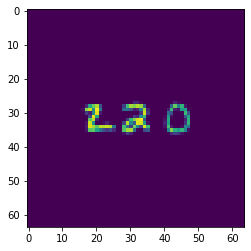

In [247]:
# Sample prediction
index = 10
y_sample = [10,10,10,10,10]

sample = np.array(x_test_segmented[index])
print("sample_shape: ", sample.shape)
# print("sample", sample)

# Flatten images to 1D vector
num_pixels = sample.shape[1] * sample.shape[2]
sample = sample.reshape((sample.shape[0], num_pixels)).astype('float32')
sample = sample / 255     # normalize inputs from 0-255 to 0-1

y_pred = model.predict(sample)
print("prediction_probabilities: ", y_pred)
y_pred = np.argmax(y_pred, axis=1)   # Find label with highest probability
print("highest_label_probabilities: ", y_pred)

num_labels = y_pred.shape[0]
y_sample[0:num_labels] = y_pred
print("sample_output: ", y_sample)

print("Image: ")
img = Image.fromarray(np.uint8(x_test[index][:,:,0]))
plt.imshow(img)
